# Output probabilities and change validation

In this notebook, we train a ResNet model with stretched images to correctly classify with high accuracy whether an image contains an invasive species of hydrangea.

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import timeit
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Datasets

We load the Invasive Species Dataset. It assumes the dataset is stored according to format of an ImageFolder dataset.

In [154]:
from torchvision import datasets, models, transforms
import os
from ScaleSquareTransform import ScaleSquare
cwd = os.getcwd()

data_transforms = {
    'train': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        ScaleSquare(224),
        transforms.ToTensor()
    ]),
}

data_dir = os.path.join(cwd,"dataset")
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes
print_every = 100
model_save_dir = os.path.join(cwd,"model_params_scaling.pth")


In [14]:
print(dset_classes)

['0', '1']


## Image sample
Plot an image just to make sure we have something that makes sense.

In [147]:
import torchvision.utils
import matplotlib.pyplot as plt

to_pil = torchvision.transforms.ToPILImage()

def show_img(inp):
    img = to_pil(inp)
    plt.imshow(img)

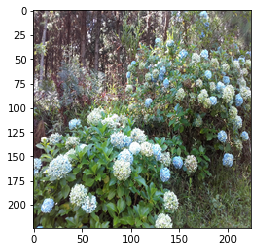

In [108]:
inputs, classes = next(iter(dset_loaders['train']))
show_img(inputs[0])

## Training
We use the following helper function to help us train a model.

In [226]:
def train(model, loss_fn, loader, optimizer, num_epochs = 1, print_every=100):
    loss_history = []
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())

            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            loss_data = loss.data[0]
            loss_history.append(loss_data)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss_data))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return loss_history

def check_accuracy(model, loader, return_errors=False, is_testing=False):
    if not is_testing:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    
    softmax_fn = nn.Softmax()
    prob_scores_corr = []
    prob_scores_incorr = []
    num_correct = 0
    num_samples = 0
    incorrect_x = {0:[],1:[]}
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(gpu_dtype), volatile=True)
        y_cuda = y.type(torch.cuda.LongTensor)

        scores = model(x_var)
        prob_score = softmax_fn(scores).data.cpu()
        #print(prob_score.size())
        #print(y)
        #print(prob_score[0,y])
        #raise
        #all_probs = torch.cat([correct_probs.squeeze(1), incorrect_probs.squeeze(1)], 1)
        #prob_scores.append(prob_score.index.data.cpu())
        #prob_scores.append(prob_score)

        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
        if return_errors:
            for i,x_i in enumerate(x):
                if (preds[i]!=y[i])[0] == 1:
                    incorrect_x[preds[i][0]].append(x_i.unsqueeze(0))
                prob_scores_corr.append(prob_score[i][y[i]])
                prob_scores_incorr.append(prob_score[i][1-y[i]])

    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc, incorrect_x, prob_scores_corr, prob_scores_incorr

In [152]:
# Verify that CUDA is properly configured and you have a GPU available
gpu_dtype = torch.cuda.FloatTensor
torch.cuda.is_available()

True

In [135]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.cuda()
model.load_state_dict(torch.load(model_save_dir))
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=10**-4.55194, betas=(0.95, 0.995), weight_decay=0.00186)

In [110]:
acc, incorrects = check_accuracy(model, dset_loaders["val"], True)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Checking accuracy on validation set
Got 431 / 439 correct (98.18)
False negatives: 5
False positives: 3


In [112]:
acc, incorrects_train = check_accuracy(model, dset_loaders["train"], True, False)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Checking accuracy on validation set
Got 1848 / 1856 correct (99.57)
False negatives: 5
False positives: 3


Now let's train again on these incorrectly classified images from the training set.

In [136]:
all_inc = []
all_inc.extend(incorrects_train[0])
all_inc.extend(incorrects_train[1])
inc_dataset = torch.cat(all_inc, 0)
targets = torch.cat([torch.LongTensor(len(incorrects_train[0])).fill_(1), torch.LongTensor(len(incorrects_train[1])).fill_(0)], 0)

In [137]:
train_incorr = torch.utils.data.TensorDataset(inc_dataset, targets)
train_incorr_loader = torch.utils.data.DataLoader(train_incorr, batch_size=4, shuffle=True)

In [138]:
all_inc_val = []
all_inc_val.extend(incorrects[0])
all_inc_val.extend(incorrects[1])
inc_dataset_val = torch.cat(all_inc_val, 0)
targets_val = torch.cat([torch.LongTensor(len(incorrects[0])).fill_(1), torch.LongTensor(len(incorrects[1])).fill_(0)], 0)
incorr_val = torch.utils.data.TensorDataset(inc_dataset_val, targets_val)
incorr_loader_val = torch.utils.data.DataLoader(incorr_val, batch_size=4, shuffle=True)

In [139]:
optimizer = optim.Adam(model.parameters(), lr=10**-4.05194, betas=(0.95, 0.995), weight_decay=0.00186)
loss_history_after = train(model, loss_fn, train_incorr_loader, optimizer, num_epochs=5)
acc, incorrects_after = check_accuracy(model, incorr_loader_val, True)
print("False negatives:",len(incorrects_after[0]))
print("False positives:",len(incorrects_after[1]))

Starting epoch 1 / 5
Starting epoch 2 / 5
Starting epoch 3 / 5
Starting epoch 4 / 5
Starting epoch 5 / 5
Checking accuracy on validation set
Got 4 / 8 correct (50.00)
False negatives: 2
False positives: 2


In [140]:
acc, incorrects_val = check_accuracy(model, dset_loaders['val'], True)
print("False negatives:",len(incorrects_val[0]))
print("False positives:",len(incorrects_val[1]))

Checking accuracy on validation set
Got 430 / 439 correct (97.95)
False negatives: 2
False positives: 2


In [156]:
model_inc_save_dir = os.path.join(cwd,"model_params_extra_incor2.pth")
torch.save(model.state_dict(), model_inc_save_dir)

Instead let's try training on the harder validation images.

In [141]:
model.load_state_dict(torch.load(model_inc_save_dir))
acc, incorrects_val = check_accuracy(model, dset_loaders['val'], True)
print("False negatives:",len(incorrects_val[0]))
print("False positives:",len(incorrects_val[1]))

Checking accuracy on validation set
Got 436 / 439 correct (99.32)
False negatives: 2
False positives: 1


## False Positives and False Negatives
Here we plot all of the false positives and false negatives.

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


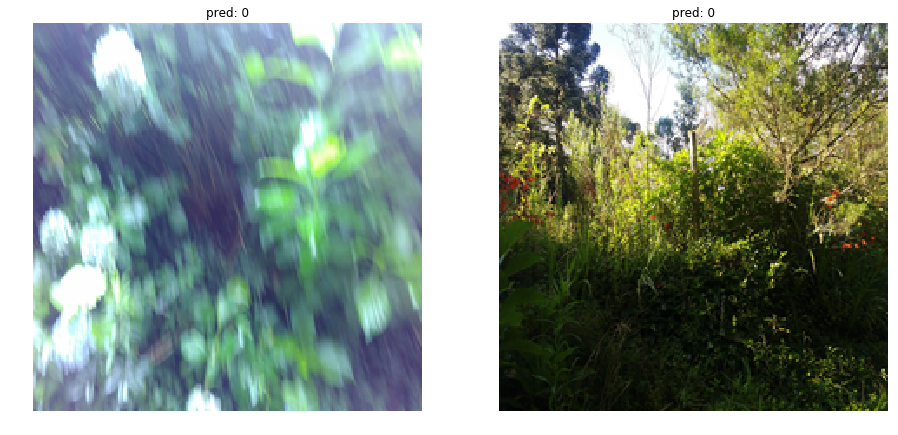

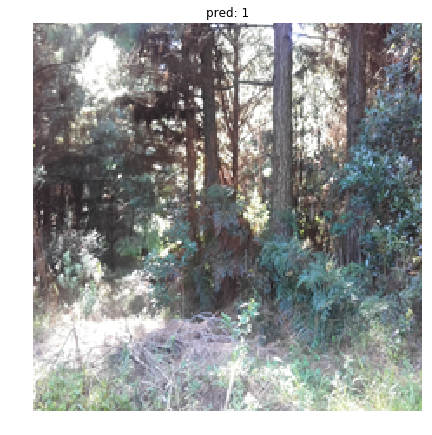

In [146]:
def plot_images(imgs, label):
    num_images = len(imgs)
    fig = plt.figure(figsize=(32, 32)) 
    for j in range(num_images):
        ax = plt.subplot(num_images//4+1, 4, j+1)
        ax.axis('off')
        ax.set_title('pred: {}'.format(label))
        show_img(imgs[j])

plot_images([x.squeeze(0) for x in incorrects_val[0]], "0")
plot_images([x.squeeze(0) for x in incorrects_val[1]], "1")

Now that it's a bit better, let's try the test set again.

In [150]:
from TestModel import TestModel

TestModel(model).submit()

Submission complete!


Test results: 0.95841 -> 0.95976

Clearly we need to try something else!

## Output probabilities instead of exact scores
We can get partial "credit" from the Kaggle interpreter for outputting probabilities instead of binary classifications. Let's try that instead.

In [231]:
acc, incorrects, prob_scores_corr, prob_scores_incorr = check_accuracy(model, dset_loaders["val"], True)
print("False negatives:",len(incorrects[0]))
print("False positives:",len(incorrects[1]))

Checking accuracy on validation set
Got 222 / 226 correct (98.23)
False negatives: 2
False positives: 2


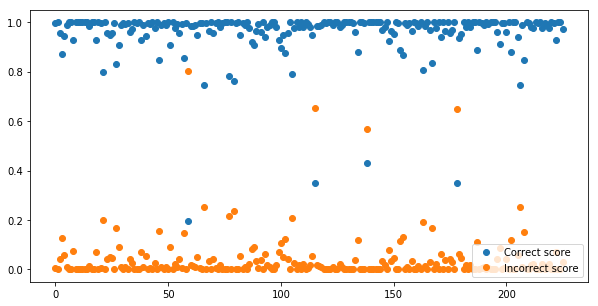

In [232]:
plt.plot(prob_scores_corr, 'o', label='Correct score')
plt.plot(prob_scores_incorr, 'o', label='Incorrect score')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(10, 5)
plt.show()

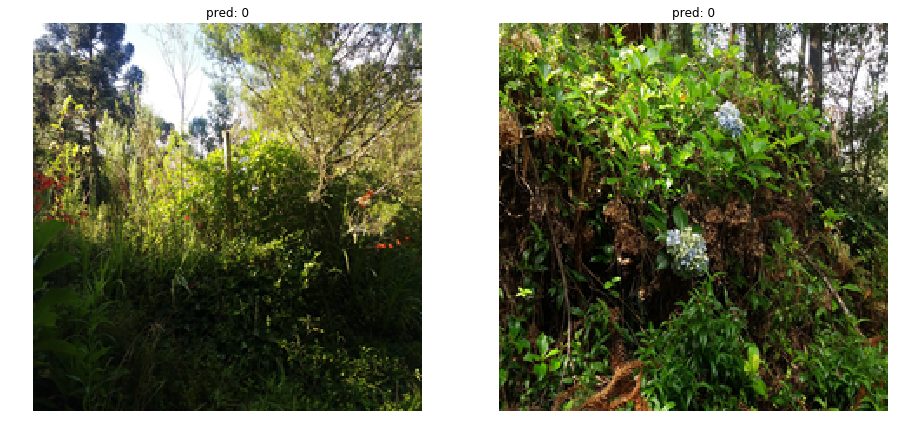

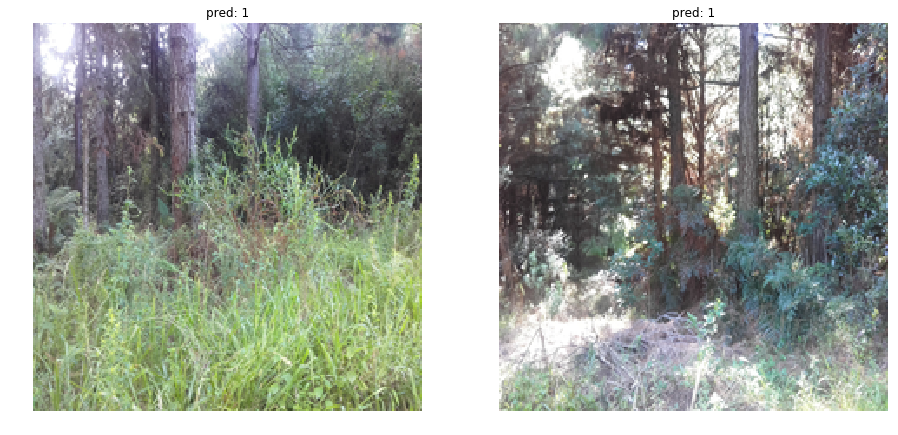

In [233]:
plot_images([x.squeeze(0) for x in incorrects[0]], "0")
plot_images([x.squeeze(0) for x in incorrects[1]], "1")

In [235]:
from TestModel import TestModel

TestModel(model, use_probs=True).send_to_kaggle("test_probs.csv", "test with probs")

Test results: 0.98812 (from 0.95841!)

## Saliency map

In [250]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X.type(gpu_dtype), requires_grad=True)
    y_var = Variable(y)
    saliency = None
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    scores = model(X_var)
    loss = loss_fn(scores, y_var)
    loss.backward()
    saliency = X_var.grad.data.abs().max(dim=1)[0].squeeze()
    return saliency

def show_saliency_maps(X, y, name):
    to_pil = torchvision.transforms.ToPILImage()
    X_tensor = torch.cat([x.unsqueeze(0) for x in X], 0)
    y_tensor = y#torch.cuda.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)

    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N = X_tensor.size()[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        show_img(X_tensor[i])
        plt.axis('off')
        plt.title(name)
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

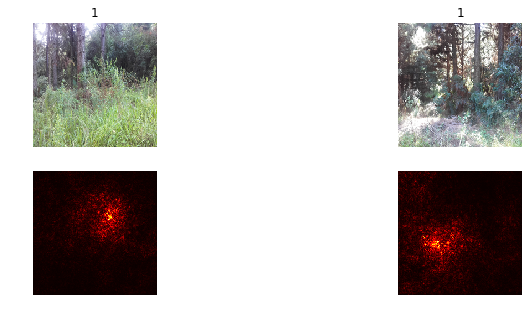

In [251]:
false_positives = incorrects[1]
show_saliency_maps(torch.cat(false_positives,0), torch.zeros(len(false_positives)).type(torch.cuda.LongTensor), '1')

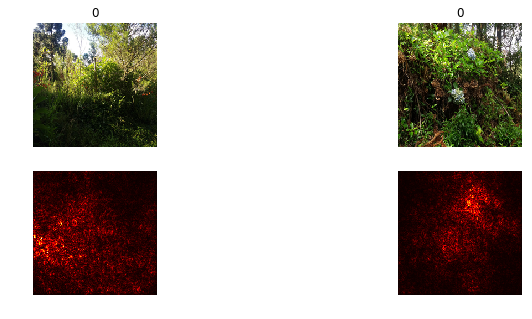

In [242]:
false_negatives = incorrects[0]
show_saliency_maps(torch.cat(false_negatives,0), torch.zeros(len(false_negatives)).type(torch.cuda.LongTensor), '0')

## Fooling

In [254]:
gpu_dtype = torch.cuda.FloatTensor

def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and wrap it in a Variable.
    X_fooling = X.clone().type(gpu_dtype)
    X_fooling_var = Variable(X_fooling, requires_grad=True)
    
    learning_rate = 1
    N, D, H, W = X_fooling.size()
    y_var = Variable(torch.cuda.LongTensor(N).fill_(target_y))
    loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
    print(y_var.data[0])
    for t in range(5):
        X_fooling_var = Variable(X_fooling, requires_grad=True)
        scores = model(X_fooling_var)
        y_pred_score, y_pred = scores.max(1)
        print("pred score, index",y_pred_score.data[0,0], y_pred.data[0,0])
        print("target score",scores.data[0,target_y])
        loss = loss_fn(scores, y_var)
        print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
        loss.backward()
        dX = X_fooling_var.grad.data/X_fooling_var.grad.data.norm()
        X_fooling -= learning_rate*dX
    return X_fooling


def show_fooling(X_tensor, X_fooling, idx, target_label, pred_label):
    x_fooling_cpu = X_fooling.cpu().clone().squeeze(0)
    x_cpu = X_tensor[idx].cpu()
    x_orig_img = to_pil(x_cpu)
    x_fooling = to_pil(x_fooling_cpu)

    plt.subplot(1, 4, 1)
    plt.imshow(x_orig_img)
    plt.title(pred_label)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(x_fooling)
    plt.title(target_label)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    #X_pre = preprocess(Image.fromarray(X[idx]))
    #diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
    diff = x_fooling_cpu-x_cpu
    plt.imshow(to_pil(diff))
    plt.title('Difference')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    #diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
    plt.imshow(to_pil(diff*10))
    plt.title('Magnified difference (10x)')
    plt.axis('off')

    plt.gcf().set_size_inches(12, 5)
    plt.show()
    
def run_fooling(errors, target_y):
    X = errors
    for idx, error in enumerate(errors):
        X_tensor_idx = torch.cat([x.cpu().unsqueeze(0) for x in X], 0)#torch.cat([preprocess(Image.fromarray(x)) for x in X], 0)
        X_fooling_idx = make_fooling_image(X_tensor_idx[idx:idx+1], target_y, model)

        scores = model(Variable(X_fooling_idx))
        assert target_y == scores.data.max(1)[1][0, 0], 'The model is not fooled!'

        show_fooling(X_tensor_idx, X_fooling_idx, idx, str(target_y), str(1-target_y))

1
pred score, index 1.168688416481018 0
target score -0.24426570534706116
t = 1, loss = 1.6308
pred score, index 1.8470375537872314 1
target score 1.8470375537872314
t = 2, loss = 0.0233
pred score, index 4.853139877319336 1
target score 4.853139877319336
t = 3, loss = 0.0000
pred score, index 8.217426300048828 1
target score 8.217426300048828
t = 4, loss = 0.0000
pred score, index 11.315495491027832 1
target score 11.315495491027832
t = 5, loss = 0.0000


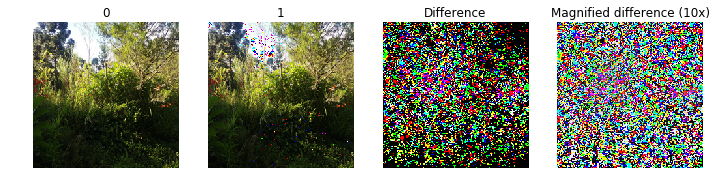

1
pred score, index 0.60947585105896 0
target score -0.017392726615071297
t = 1, loss = 1.0549
pred score, index 3.493619203567505 1
target score 3.493619203567505
t = 2, loss = 0.0004
pred score, index 7.471540927886963 1
target score 7.471540927886963
t = 3, loss = 0.0000
pred score, index 10.548415184020996 1
target score 10.548415184020996
t = 4, loss = 0.0000
pred score, index 13.122380256652832 1
target score 13.122380256652832
t = 5, loss = 0.0000


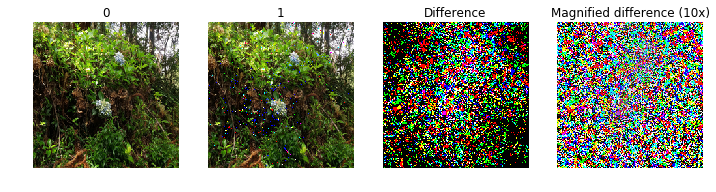

In [256]:
run_fooling(torch.cat(incorrects[0],0), 1)

0
pred score, index 0.1718195676803589 1
target score -0.10665383189916611
t = 1, loss = 0.8420
pred score, index 2.1613316535949707 0
target score 2.1613316535949707
t = 2, loss = 0.0346
pred score, index 3.9296529293060303 0
target score 3.9296529293060303
t = 3, loss = 0.0015
pred score, index 5.390395641326904 0
target score 5.390395641326904
t = 4, loss = 0.0001
pred score, index 6.243415355682373 0
target score 6.243415355682373
t = 5, loss = 0.0000


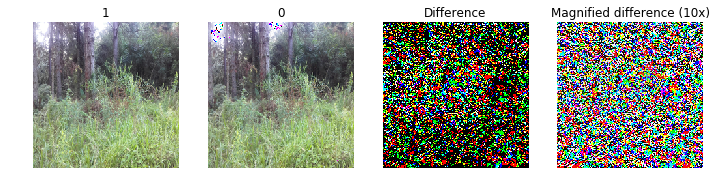

0
pred score, index 0.3586735427379608 1
target score -0.2554236948490143
t = 1, loss = 1.0466
pred score, index 2.3958470821380615 0
target score 2.3958470821380615
t = 2, loss = 0.0140
pred score, index 4.643499851226807 0
target score 4.643499851226807
t = 3, loss = 0.0004
pred score, index 6.454667091369629 0
target score 6.454667091369629
t = 4, loss = 0.0000
pred score, index 7.558108806610107 0
target score 7.558108806610107
t = 5, loss = 0.0000


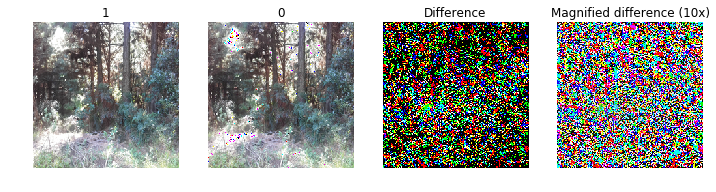

In [257]:
run_fooling(torch.cat(incorrects[1],0), 0)